# Imports

In [1]:
# Machine Learning 
from sklearn import svm
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.decomposition import PCA

# ML Evaluation
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, roc_auc_score, roc_curve, auc

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns


# Utils
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import pickle


# Dataset Preprocessing

In [2]:
train_path = '../car-damage-dataset/data1a/training'
test_path = '../car-damage-dataset/data1a/validation'

train_files = glob(train_path + '/*/*.jp*g')
test_files = glob(test_path + '/*/*.jp*g')

In [3]:
os.listdir(test_path)

['00-damage', '01-whole']

In [4]:
def load_images_as_vectors(images):
    """
    helper function to convert glob to vector
    """
    
    number_of_images = len(images)
    w = 256
    h = 256
    channels = 3

    X = np.empty(shape= (number_of_images, w*h*channels))

    labels = np.empty(number_of_images)

    for i, sample in enumerate(images):

        image_vector = Image.open(sample) 
        
        # Resize to 256 x 256
        resized_image_vector = np.array(image_vector.resize((256, 256)))

        # Scale to [0,1]
        norm_image_vector = resized_image_vector / 255

        flattened_image_vector = norm_image_vector.flatten()

        X[i] = np.pad(flattened_image_vector, (0, (w*h*channels) - len(flattened_image_vector) ))

        if sample.split("\\")[-2] == "00-damage":
            labels[i] = 0

        else:
            labels[i] = 1

    return X, labels


### Dimensionality Reduction

In [5]:

X1, y1 = load_images_as_vectors(train_files)

X2, y2 = load_images_as_vectors(test_files)

X = np.append(X1, X2, axis=0)

y = np.append(y1, y2, axis=0)

principal=PCA()

principal.fit(X)


PCA()

Text(0, 0.5, 'cumulative explained variance')

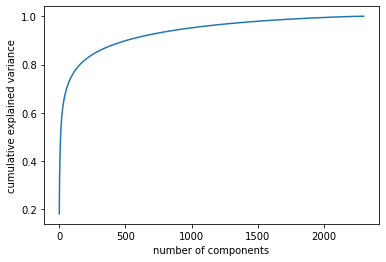

In [6]:
plt.plot(np.cumsum(principal.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
principal = PCA(n_components=1500)

principal.fit(X)

X=principal.transform(X)

## Test/Train splits

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [9]:
len(y)

2300

## Model Development

In [10]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}

svc = svm.SVC()

model = HalvingGridSearchCV(svc, param_grid, n_jobs=-1, cv=5, verbose=1)

model.fit(X_train, y_train)

print(model.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 68
max_resources_: 1840
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 68
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 11
n_resources: 204
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 2
n_candidates: 4
n_resources: 612
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 1836
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [11]:
y_pred = model.predict(X_test)

# y_pred

## Model Performance Review

In [12]:
accuracy_score(y_pred, y_test)

0.7217391304347827

In [13]:
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74       257
         1.0       0.67      0.72      0.70       203

    accuracy                           0.72       460
   macro avg       0.72      0.72      0.72       460
weighted avg       0.73      0.72      0.72       460



<AxesSubplot:>

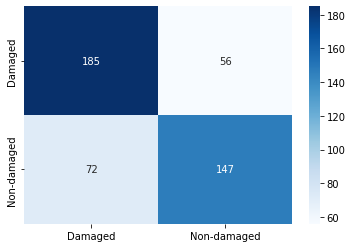

In [14]:
confusion_matrix(y_test, y_pred)

sns.heatmap(
   pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index = ['Damaged', 'Non-damaged'],
    columns = ['Damaged', 'Non-damaged']
), 
    annot=True, 
    fmt='g', 
    cmap='Blues'
    )

In [15]:
roc_auc_score(y_pred, y_test)

0.7219911445055682

In [16]:
y_score = model.decision_function(X_test)


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

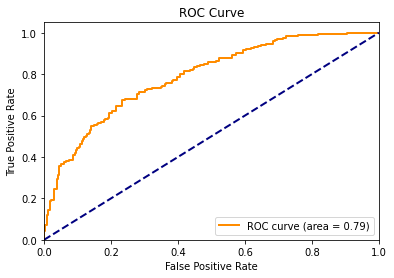

In [17]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [18]:
# Use pickle to save the model
pickle.dump(model,open('../saved-models/final_model.p','wb'))

# Use pickle to save PCA
pickle.dump(principal, open("../saved-models/pca.pkl","wb"))

# pca.pkl file will not be updated to github due to its very large size